In [1]:
from pendulum import Pendulum_2D
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.interpolate import CubicSpline
from IPython.display import clear_output

In [13]:
y0 = np.array([np.pi/4, 0]) 
t0 = 0
m = 10
l = 10
tf = 100
time_step = 0.1


rk4 = Pendulum_2D(m, l) 
rk4.set_initial_condition(t0, y0, "canonical")
rk4.integrate("RK4", tf, "generalized", h = time_step)    
rk4.calculate_hamiltonian()

In [14]:
y0 = np.array([np.pi/4, 0]) 
t0 = 0
m = 10
l = 10
tf = 100
time_step = 0.1

cases = []

benchmark = Pendulum_2D(m, l)
benchmark.set_initial_condition(t0, y0, "canonical")
benchmark.integrate("dop853", tf, "generalized", rtol = 1e-12, atol = 1e-12)

for method in tqdm(['euler', 'leapfrog', "RK4"]):
    for time_step in tqdm(np.geomspace(0.0001, 1, 5), leave = False): 
        
        case = Pendulum_2D(m, l)
        case.set_initial_condition(t0, y0, "canonical") 
        
        if method == "RK4": 
            case.integrate(method, tf, "generalized", h = time_step) 
        else: 
            case.integrate(method, tf, "canonical", h = time_step) 

        cases.append(case) 
        clear_output(wait=True)
        
benchmark.calculate_hamiltonian()
for case in cases: 
    case.calculate_hamiltonian()


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:42<00:00, 14.00s/it]


In [15]:
for case in cases: 
    print(f"{case.integrator}, {case.propagator}, {case.time_step}")

euler, <bound method Pendulum_2D.Hamilton of <pendulum.Pendulum_2D object at 0x00000264CBA32A40>>, 0.0001
euler, <bound method Pendulum_2D.Hamilton of <pendulum.Pendulum_2D object at 0x00000264CBA32F20>>, 0.001
euler, <bound method Pendulum_2D.Hamilton of <pendulum.Pendulum_2D object at 0x00000264CBA32F80>>, 0.01
euler, <bound method Pendulum_2D.Hamilton of <pendulum.Pendulum_2D object at 0x00000264CBA32E60>>, 0.1
euler, <bound method Pendulum_2D.Hamilton of <pendulum.Pendulum_2D object at 0x00000264CBA32F50>>, 1.0
leapfrog, <bound method Pendulum_2D.Hamilton of <pendulum.Pendulum_2D object at 0x00000264CBA32EF0>>, 0.0001
leapfrog, <bound method Pendulum_2D.Hamilton of <pendulum.Pendulum_2D object at 0x00000264CBA32AD0>>, 0.001
leapfrog, <bound method Pendulum_2D.Hamilton of <pendulum.Pendulum_2D object at 0x00000264CBA32B60>>, 0.01
leapfrog, <bound method Pendulum_2D.Hamilton of <pendulum.Pendulum_2D object at 0x00000264CBA33010>>, 0.1
leapfrog, <bound method Pendulum_2D.Hamilton of <

In [16]:
cs = CubicSpline(benchmark.states["generalized"][:,0], benchmark.states["generalized"][:,1])

Text(0, 0.5, 'Position error at final time')

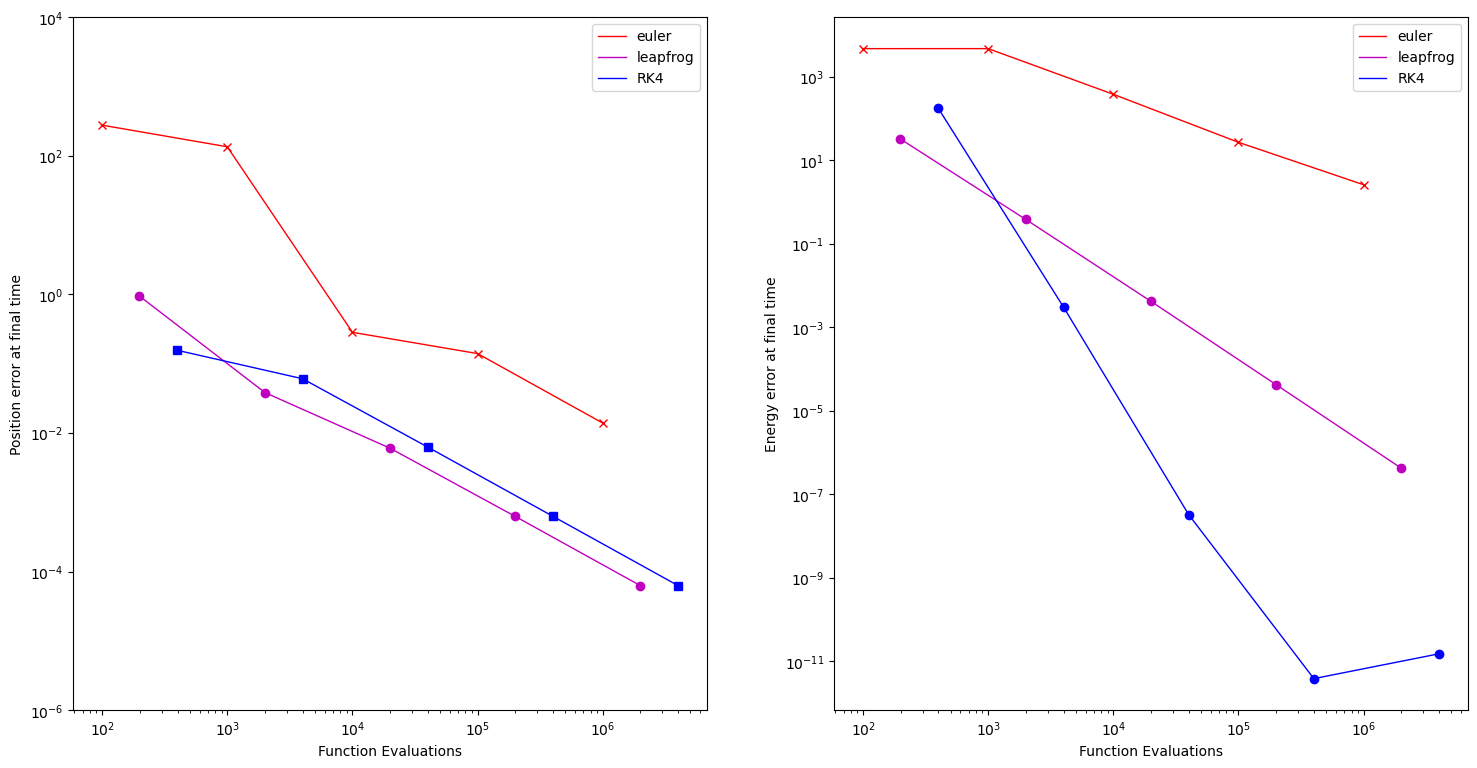

In [45]:
fig, axes = plt.subplots(1, 2, figsize = (18, 9)) 

colors = {"RK4": 'b', 
          "euler": 'r', 
          "leapfrog": 'm'}
          
for case in cases: 
    
    if case.integrator == "euler":
        axes[0].plot(case.evals, abs(case.states['canonical'][-1,1] - cs(case.states['canonical'][-1,0])), 'x', color = colors[case.integrator]) 
        axes[1].plot(case.evals, abs(case.hamiltonian[-1] - case.hamiltonian[0]), 'x', color = colors[case.integrator])
        
    if case.integrator == "leapfrog":
        axes[0].plot(case.evals, abs(case.states['canonical'][-1,1] - cs(case.states['canonical'][-1,0])), 'o', color = colors[case.integrator]) 
        axes[1].plot(case.evals, abs(case.hamiltonian[-1] - case.hamiltonian[0]), 'o', color = colors[case.integrator])

    if case.integrator == "RK4":
        axes[0].plot(case.evals, abs(case.states['generalized'][-1,1] - cs(case.states['generalized'][-1,0])), 's', color = colors[case.integrator]) 
        axes[1].plot(case.evals, abs(case.hamiltonian[-1] - case.hamiltonian[0]), 'o', color = colors[case.integrator])

        
for method in ['euler', 'leapfrog', "RK4"]: 
    
    X1 = []
    Y1 = []
    X2 = []
    Y2 = []
    
    for case in cases: 
        if case.integrator == method: 
            X1.append(case.evals)

            if method == "RK4": 
                Y1.append(abs(case.states['generalized'][-1,1] - cs(case.states['generalized'][-1,0])))
            else:
                Y1.append(abs(case.states['canonical'][-1,1] - cs(case.states['canonical'][-1,0])))
            
            X2.append(case.evals) 
            Y2.append(abs(case.hamiltonian[-1] - case.hamiltonian[0]))

    axes[0].plot(X1, Y1, linewidth = 1, label = method, color = colors[method]) 
    axes[1].plot(X2, Y2, linewidth = 1, label = method, color = colors[method]) 


axes[1].set_xscale("log") 
axes[1].set_yscale("log") 
axes[1].legend()
axes[1].set_xlabel("Function Evaluations")
axes[1].set_ylabel("Energy error at final time")

axes[0].set_xscale("log") 
axes[0].set_yscale("log") 
axes[0].legend()
axes[0].set_ylim(1e-6, 1e4) 
# axes[0].set_xlim(10, 1e7)
axes[0].set_xlabel("Function Evaluations")
axes[0].set_ylabel("Position error at final time")

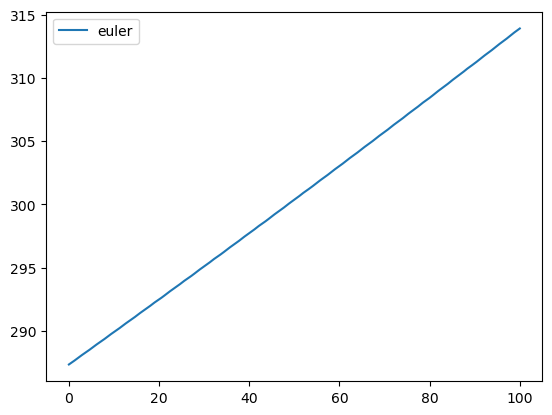

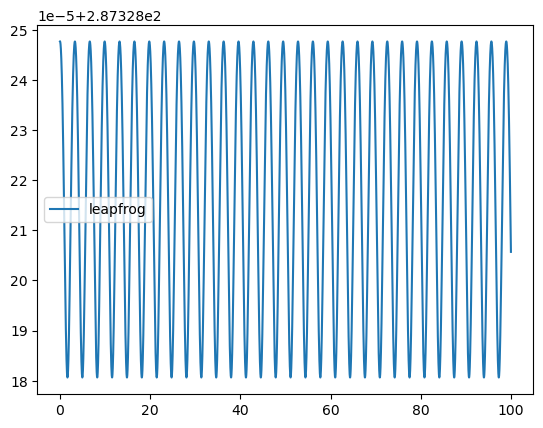

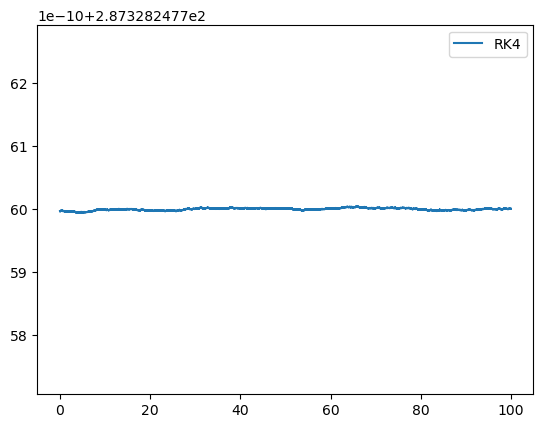

In [30]:
for case in cases: 
    if case.time_step == 0.001: 
        plt.plot(case.states['canonical'][:,0], case.hamiltonian, label = case.integrator)
        plt.legend()
        plt.show()


In [47]:
import pickle

for i, case in enumerate(cases): 
    with open(f'data/case_{i}.pkl', 'wb') as f:
        pickle.dump(case, f)